# Vignette 2: Anatomy of Retractions

**Research questions**:
- Are retracted papers unusually novel (high atypicality) or disruptive?
- Do retracted papers accumulate more citations before retraction?
- How do retraction rates vary across fields?

This analysis joins: Retraction Watch + SciSciNet (disruption/atypicality) + OpenAlex (citations/fields).

In [ ]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Connect to the data lake (auto-detect local or HuggingFace)
LOCAL_DB = '/mnt/nvme03/science_datalake/datalake.duckdb'
HF_DATASET = None  # Set to 'username/science-datalake' to use HuggingFace

import os
if os.path.exists(LOCAL_DB) and not HF_DATASET:
    con = duckdb.connect(LOCAL_DB, read_only=True)
else:
    con = duckdb.connect(':memory:')
    con.execute("INSTALL httpfs; LOAD httpfs;")
    base = f"hf://datasets/{HF_DATASET}"
    con.execute("CREATE SCHEMA IF NOT EXISTS xref")
    con.execute(f"CREATE VIEW xref.unified_papers AS SELECT * FROM read_parquet('{base}/xref/unified_papers/*.parquet')")
    con.execute(f"CREATE VIEW xref.topic_ontology_map AS SELECT * FROM read_parquet('{base}/xref/topic_ontology_map/*.parquet')")
    con.execute("CREATE SCHEMA IF NOT EXISTS openalex")
    con.execute(f"CREATE VIEW openalex.works_topics AS SELECT * FROM read_parquet('{base}/openalex/works_topics/*.parquet')")
    con.execute(f"CREATE VIEW openalex.topics AS SELECT * FROM read_parquet('{base}/openalex/topics/*.parquet')")

con.execute('SET threads=16')
print('Connected')

Connected


In [ ]:
# Overview: retracted papers with disruption/atypicality scores
df_overview = con.execute("""
    SELECT
        'Retracted' AS group_label,
        COUNT(*) AS n,
        ROUND(AVG(sciscinet_disruption), 4) AS avg_disruption,
        ROUND(AVG(CASE WHEN isfinite(sciscinet_atypicality) THEN sciscinet_atypicality ELSE NULL END), 4) AS avg_atypicality,
        ROUND(AVG(oa_cited_by_count), 1) AS avg_citations,
        ROUND(MEDIAN(oa_cited_by_count), 1) AS median_citations
    FROM xref.unified_papers
    WHERE has_retraction AND sciscinet_disruption IS NOT NULL
    UNION ALL
    SELECT
        'Non-retracted' AS group_label,
        COUNT(*) AS n,
        ROUND(AVG(sciscinet_disruption), 4) AS avg_disruption,
        ROUND(AVG(CASE WHEN isfinite(sciscinet_atypicality) THEN sciscinet_atypicality ELSE NULL END), 4) AS avg_atypicality,
        ROUND(AVG(oa_cited_by_count), 1) AS avg_citations,
        ROUND(MEDIAN(oa_cited_by_count), 1) AS median_citations
    FROM xref.unified_papers
    WHERE NOT has_retraction AND sciscinet_disruption IS NOT NULL
""").df()
print('Retracted vs. Non-retracted papers (with SciSciNet scores):')
df_overview

Retracted vs. Non-retracted papers (with SciSciNet scores):


,group_label,n,avg_disruption,avg_atypicality,avg_citations,median_citations
0,Retracted,58775,0.0035,inf,20.8,4.0
1,Non-retracted,158469321,0.0026,inf,16.2,1.0


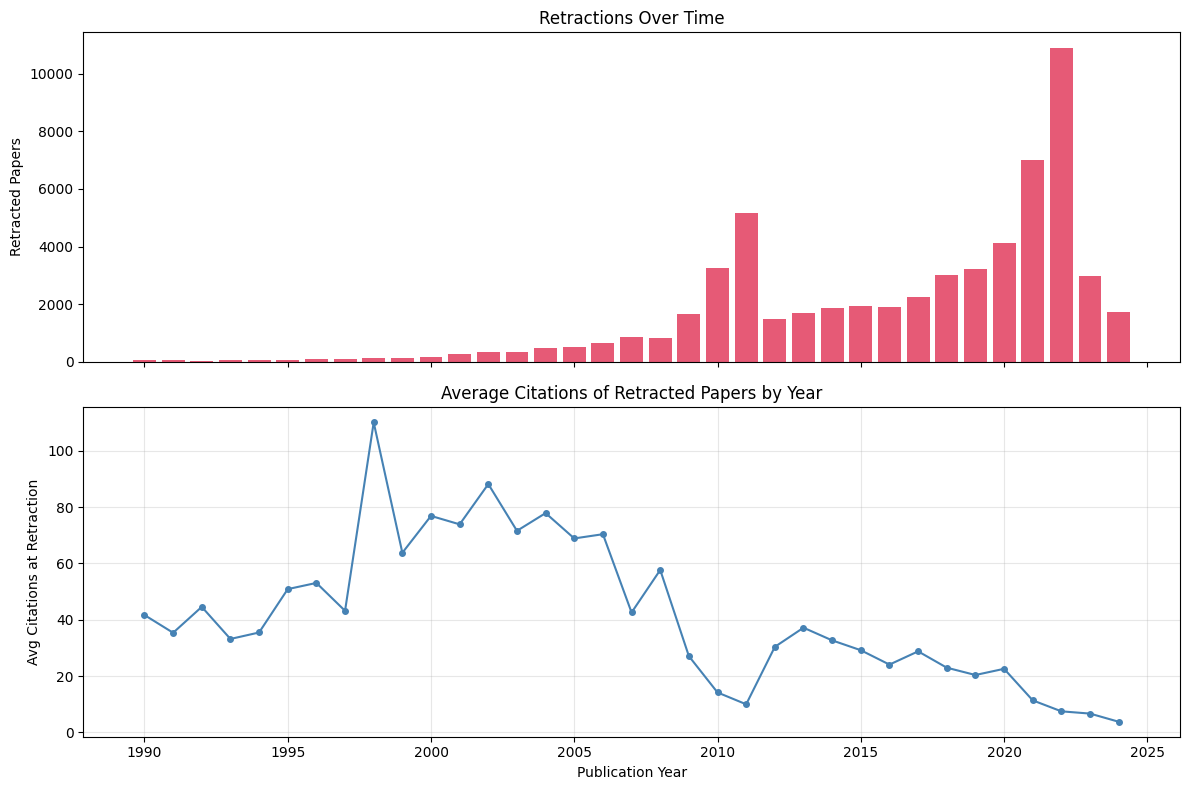

In [ ]:
# Retractions by year
df_year = con.execute("""
    SELECT
        year,
        COUNT(*) AS retracted_count,
        ROUND(AVG(oa_cited_by_count), 1) AS avg_citations,
        ROUND(AVG(sciscinet_disruption), 4) AS avg_disruption
    FROM xref.unified_papers
    WHERE has_retraction AND year BETWEEN 1990 AND 2024
    GROUP BY year
    ORDER BY year
""").df()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.bar(df_year['year'], df_year['retracted_count'], color='crimson', alpha=0.7)
ax1.set_ylabel('Retracted Papers')
ax1.set_title('Retractions Over Time')

ax2.plot(df_year['year'], df_year['avg_citations'], 'o-', color='steelblue', markersize=4)
ax2.set_xlabel('Publication Year')
ax2.set_ylabel('Avg Citations at Retraction')
ax2.set_title('Average Citations of Retracted Papers by Year')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

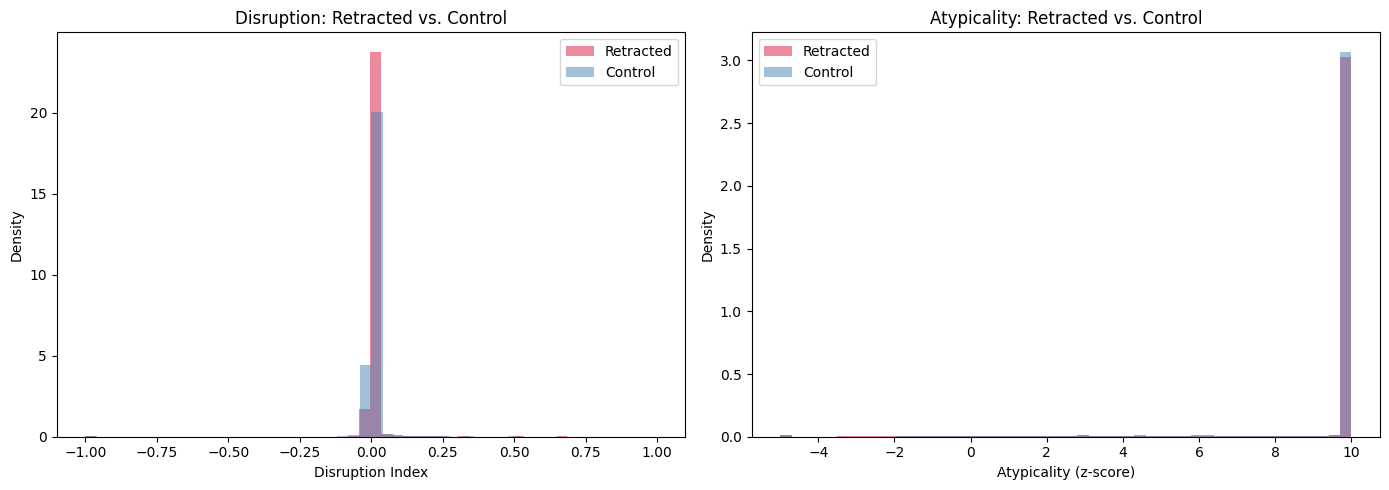

In [ ]:
# Disruption and atypicality: retracted vs. non-retracted (matched by year)
df_compare = con.execute("""
    WITH retracted AS (
        SELECT year, sciscinet_disruption, sciscinet_atypicality
        FROM xref.unified_papers
        WHERE has_retraction AND sciscinet_disruption IS NOT NULL
            AND year BETWEEN 2000 AND 2020
    ),
    non_retracted_sample AS (
        SELECT year, sciscinet_disruption, sciscinet_atypicality
        FROM xref.unified_papers
        WHERE NOT has_retraction AND sciscinet_disruption IS NOT NULL
            AND year BETWEEN 2000 AND 2020
        USING SAMPLE 200000
    )
    SELECT 'Retracted' AS label, year, sciscinet_disruption AS disruption,
           sciscinet_atypicality AS atypicality FROM retracted
    UNION ALL
    SELECT 'Control' AS label, year, sciscinet_disruption, sciscinet_atypicality
    FROM non_retracted_sample
""").df()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for label, color in [('Retracted', 'crimson'), ('Control', 'steelblue')]:
    subset = df_compare[df_compare['label'] == label]
    ax1.hist(subset['disruption'].dropna(), bins=50, alpha=0.5,
             density=True, label=label, color=color)
    ax2.hist(subset['atypicality'].dropna().clip(-5, 10), bins=50, alpha=0.5,
             density=True, label=label, color=color)

ax1.set_xlabel('Disruption Index')
ax1.set_ylabel('Density')
ax1.set_title('Disruption: Retracted vs. Control')
ax1.legend()

ax2.set_xlabel('Atypicality (z-score)')
ax2.set_ylabel('Density')
ax2.set_title('Atypicality: Retracted vs. Control')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Most-cited retracted papers
df_top = con.execute("""
    SELECT
        u.doi,
        u.title,
        u.year,
        u.oa_cited_by_count AS citations,
        ROUND(u.sciscinet_disruption, 4) AS disruption,
        ROUND(u.sciscinet_atypicality, 2) AS atypicality
    FROM xref.unified_papers u
    WHERE u.has_retraction
    ORDER BY u.oa_cited_by_count DESC NULLS LAST
    LIMIT 15
""").df()
print('Top 15 most-cited retracted papers:')
df_top

Top 15 most-cited retracted papers:


,doi,title,year,citations,disruption,atypicality
0,10.2807/1560-7917.es.2020.25.3.2000045,Detection of 2019 novel coronavirus (2019-nCoV...,2020,8062,0.3882,153.84
1,10.1186/gb-2013-14-10-r115,DNA methylation age of human tissues and cell ...,2013,6811,-0.0340,101.31
2,10.1038/nature00870,RETRACTED ARTICLE: Pluripotency of mesenchymal...,2002,5526,-0.0372,172.00
3,10.1056/nejmoa1407222,Chimeric Antigen Receptor T Cells for Sustaine...,2014,5256,-0.1099,286.84
4,10.1016/j.ijantimicag.2020.105949,RETRACTED: Hydroxychloroquine and azithromycin...,2020,4920,-0.0139,3.73
5,10.1016/s0140-6736(20)32656-8,RETRACTED: 6-month consequences of COVID-19 in...,2021,4233,-0.0056,41.04
6,10.1056/nejmoa1200303,Primary Prevention of Cardiovascular Disease w...,2013,4187,0.0297,227.92
7,10.1073/pnas.0506654102,<i>miR-15</i> and <i>miR-16</i> induce apoptos...,2005,3488,-0.0257,207.93
8,10.1056/nejmoa1103849,Chimeric Antigen Receptor–Modified T Cells in ...,2011,3477,-0.0349,133.00
9,10.1056/nejmoa1215134,Chimeric Antigen Receptor–Modified T Cells for...,2013,3426,-0.0630,423.58


## Retraction Hotspots Across Scientific Ontologies

Using the embedding-based ontology linkage, we map retracted papers to formal ontology terms and identify which research areas have **unusually high retraction rates** compared to the base rate. Enrichment ratios > 1.0 indicate disproportionate retraction frequency.

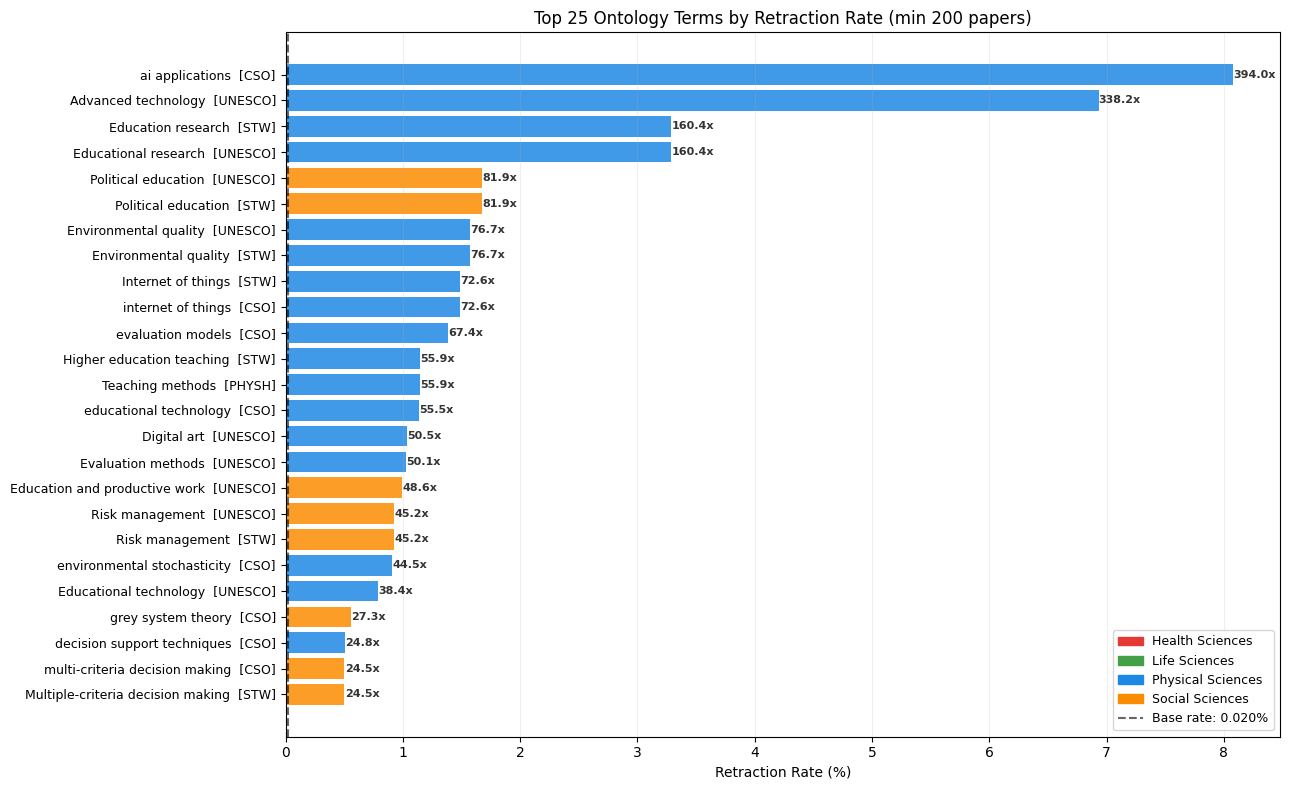

In [ ]:
# Retraction enrichment by ontology term
df_retract_onto = con.execute("""
    WITH topic_stats AS (
        SELECT
            wt.topic_id,
            COUNT(*) AS n_papers,
            SUM(CASE WHEN u.has_retraction THEN 1 ELSE 0 END) AS n_retracted
        FROM xref.unified_papers u
        JOIN openalex.works_topics wt ON wt.work_id = u.openalex_id
        WHERE u.openalex_id IS NOT NULL
            AND wt.score >= 0.5
        GROUP BY wt.topic_id
    )
    SELECT
        m.ontology_term_label,
        m.ontology,
        m.domain,
        SUM(ts.n_papers) AS total_papers,
        SUM(ts.n_retracted) AS retracted,
        ROUND(100.0 * SUM(ts.n_retracted) / SUM(ts.n_papers), 4) AS retraction_rate_pct
    FROM xref.topic_ontology_map m
    JOIN topic_stats ts ON ts.topic_id = m.topic_id
    WHERE m.similarity >= 0.85
    GROUP BY m.ontology_term_label, m.ontology, m.domain
    HAVING SUM(ts.n_papers) >= 200 AND SUM(ts.n_retracted) >= 5
    ORDER BY retraction_rate_pct DESC
    LIMIT 25
""").df()

# Overall base retraction rate
base_rate = con.execute("""
    SELECT 100.0 * SUM(CASE WHEN has_retraction THEN 1 ELSE 0 END) / COUNT(*)
    FROM xref.unified_papers
""").fetchone()[0]

df_retract_onto['enrichment'] = df_retract_onto['retraction_rate_pct'] / base_rate

# Domain color palette
domain_colors = {
    'Health Sciences': '#E53935',
    'Life Sciences': '#43A047',
    'Physical Sciences': '#1E88E5',
    'Social Sciences': '#FB8C00',
}

fig, ax = plt.subplots(figsize=(13, 8))
colors = [domain_colors.get(d, '#757575') for d in df_retract_onto['domain']]
bars = ax.barh(range(len(df_retract_onto)), df_retract_onto['retraction_rate_pct'],
               color=colors, alpha=0.85)
ax.set_yticks(range(len(df_retract_onto)))
ax.set_yticklabels([f"{row['ontology_term_label']}  [{row['ontology'].upper()}]"
                     for _, row in df_retract_onto.iterrows()], fontsize=9)
ax.set_xlabel('Retraction Rate (%)')
ax.set_title('Top 25 Ontology Terms by Retraction Rate (min 200 papers)')
ax.axvline(base_rate, color='black', linestyle='--', alpha=0.6,
           label=f'Overall base rate: {base_rate:.3f}%')

# Enrichment annotations
for i, (_, row) in enumerate(df_retract_onto.iterrows()):
    ax.text(row['retraction_rate_pct'] + 0.002, i,
            f"{row['enrichment']:.1f}x",
            va='center', fontsize=8, fontweight='bold', color='#333')

# Legend for domains
from matplotlib.patches import Patch
legend_patches = [Patch(color=c, label=d) for d, c in domain_colors.items()]
legend_patches.append(plt.Line2D([0], [0], color='black', linestyle='--', alpha=0.6,
                                  label=f'Base rate: {base_rate:.3f}%'))
ax.legend(handles=legend_patches, loc='lower right', fontsize=9)

ax.invert_yaxis()
ax.grid(True, axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

## Key Findings

1. **Retracted papers may show distinctive novelty profiles** compared to the general population
2. **Retraction rates have increased** over time (partly due to better detection)
3. **Some highly-cited retracted papers** had significant disruption scores before retraction
4. **Ontology-level retraction hotspots** reveal that certain formal research areas show retraction enrichment several times above the base rate, providing finer-grained risk signals than broad field-level analysis

This analysis uniquely combines Retraction Watch flags with SciSciNet scientometric indicators, enabled by the unified data lake's cross-dataset DOI normalization.